In [46]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Opening all data

## Object detection

In [47]:
image_files_art = [f for f in os.listdir('images/images_art') if os.path.isfile(os.path.join('images/images_art', f))]
image_files_nat = [f for f in os.listdir('images/images_nat') if os.path.isfile(os.path.join('images/images_nat', f))]

detected_objects_per_image_total = pd.read_csv('data_out/object_detection/objects_per_image.csv')
detected_objects_per_image_art = detected_objects_per_image_total[detected_objects_per_image_total['image_file'].isin(image_files_art)]
detected_objects_per_image_nat = detected_objects_per_image_total[detected_objects_per_image_total['image_file'].isin(image_files_nat)]

## Boxes and Matches

In [48]:
participant_boxes_total = pd.read_csv('data/experiment_boxes.csv', index_col=0)
box_matches_total = pd.read_csv('data_out/object_detection/box_matches.csv', index_col=0)

box_matches_total = box_matches_total.merge(participant_boxes_total[['id', 'experiment']], left_on='box_id', right_on='Index', how='left').drop(columns=['id'])
box_matches_total = box_matches_total.merge(participant_boxes_total[['id', 'file_name']], left_on='box_id', right_on='Index', how='left').drop(columns=['id'])

box_matches_art = box_matches_total[box_matches_total['experiment'].isin([1, 2])]
participant_boxes_art = participant_boxes_total[participant_boxes_total['experiment'].isin([1, 2])]

box_matches_nat = box_matches_total[box_matches_total['experiment'].isin([3, 4])]
participant_boxes_nat = participant_boxes_total[participant_boxes_total['experiment'].isin([3, 4])]

## Homogeneity

In [49]:
homogeneity_total = pd.read_csv('data_out/object_detection/homogeneities.csv', index_col=0)

homogeneity_total = homogeneity_total.merge(participant_boxes_total[['id', 'experiment']], left_on='box_id', right_on='Index', how='left').drop(columns=['id'])

homogeneity_art = homogeneity_total[homogeneity_total['experiment'].isin([1, 2])]
homogeneity_nat = homogeneity_total[homogeneity_total['experiment'].isin([3, 4])]

## Selecting subset of the data

In [50]:
box_matches = box_matches_nat
participant_boxes = participant_boxes_nat
detected_objects_per_image = detected_objects_per_image_nat
homogeneity = homogeneity_nat

# Analysis of detected objects (image Level)

## How many images contained objects

In [51]:
num_boxes_with_predictions = len(detected_objects_per_image[detected_objects_per_image['num_predictions'] > 0])
images_with_predictions = detected_objects_per_image[detected_objects_per_image['num_predictions'] > 0]['image_file'].tolist()

print(f'Out of all {len(detected_objects_per_image)} images, {num_boxes_with_predictions} ({num_boxes_with_predictions/len(detected_objects_per_image)*100:.2f}%) images had at least one object detected.')

Out of all 200 images, 129 (64.50%) images had at least one object detected.


## How unique are the objects

In [52]:
model_classes = list(detected_objects_per_image.columns[2:])

non_zero_columns = detected_objects_per_image[model_classes].apply(lambda col: col.gt(0).any())
num_non_zero_columns = non_zero_columns.sum()
print(f'There are {num_non_zero_columns} unique objects detected in the dataset.')

There are 63 unique objects detected in the dataset.


## Graph quantity of objects

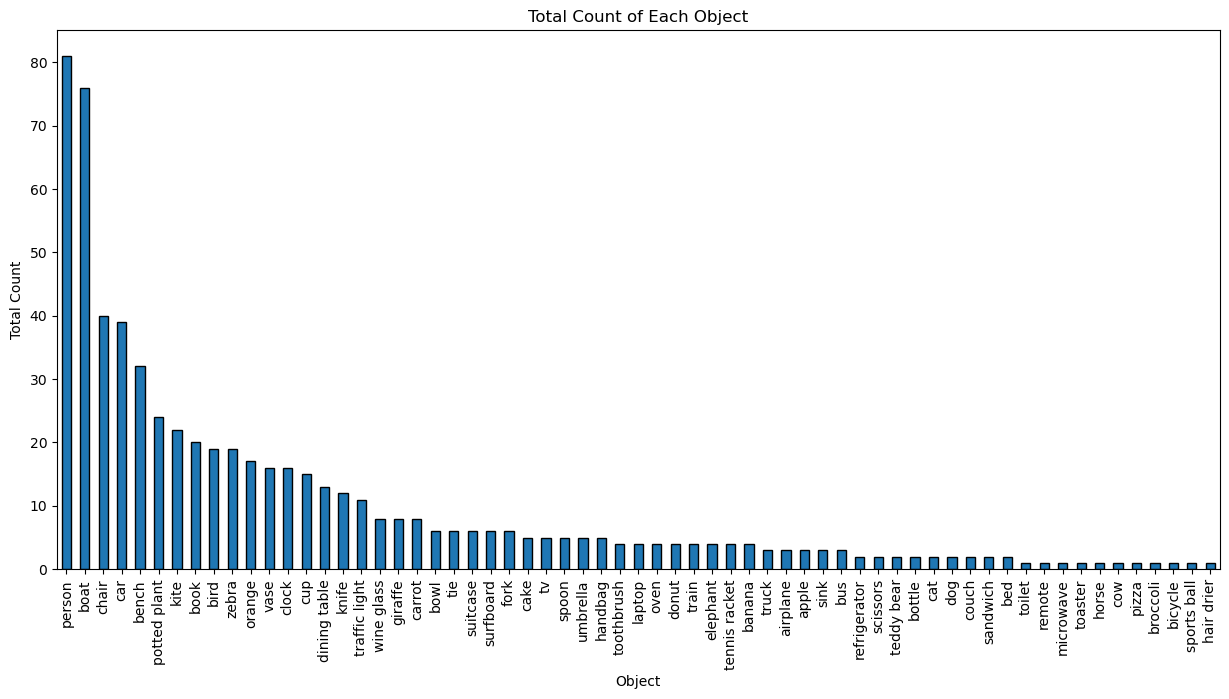

In [53]:
# Filter the detected_objects_per_image dataframe to include only the columns in non_zero_columns
filtered_objects = detected_objects_per_image[non_zero_columns.index[non_zero_columns]]

# Sum the values of each column to get the total count of each object
object_counts = filtered_objects.sum()

# Order the object_counts from bigger to smaller
object_counts = object_counts.sort_values(ascending=False)

# Create a bar plot
object_counts.plot(kind='bar', figsize=(15, 7), edgecolor='black')
plt.title('Total Count of Each Object')
plt.xlabel('Object')
plt.ylabel('Total Count')

plt.show()

# What threshold should we choose?

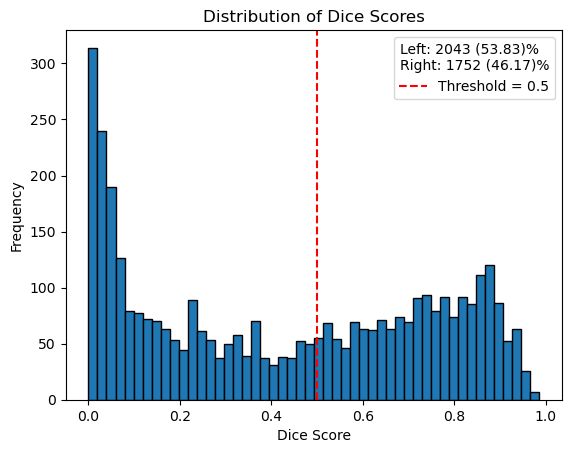

In [54]:
threshold = 0.5

matched_boxes = box_matches[box_matches['match_id'] > 0]
thresholded_boxes = matched_boxes[matched_boxes['dice_score'] > threshold]

plt.hist(matched_boxes['dice_score'], bins=50, edgecolor='black')
plt.title('Distribution of Dice Scores')
plt.axvline(x=threshold, color='r', linestyle='--', label=f'Threshold = {threshold}')
left_count = (matched_boxes['dice_score'] <= threshold).sum()
right_count = (matched_boxes['dice_score'] > threshold).sum()
plt.legend(title=f'Left: {left_count} ({left_count/len(matched_boxes)*100:.2f})%\nRight: {right_count} ({right_count/len(matched_boxes)*100:.2f})%')
plt.xlabel('Dice Score')
plt.ylabel('Frequency')
plt.show()

# Do people mostly label objects?

## Percentage of boxes matched with objects (out of all images)

In [55]:
print(f'Out of the {len(participant_boxes)} selected boxes, {len(thresholded_boxes)} ({len(thresholded_boxes)/len(participant_boxes)*100:.2f}%) were matched to a detected object.')

Out of the 17129 selected boxes, 1752 (10.23%) were matched to a detected object.


## Percentage of boxes matched with objects (in images with detections)

In [56]:
matched_boxes_on_detected_images = box_matches[box_matches['file_name'].isin(images_with_predictions)]

print(f'Out of the {len(matched_boxes_on_detected_images)} selected boxes in images where detection happened, {len(thresholded_boxes)} ({len(thresholded_boxes)/len(matched_boxes_on_detected_images)*100:.2f}%) were matched to a detected object.')

Out of the 11412 selected boxes in images where detection happened, 1752 (15.35%) were matched to a detected object.


# Is the number of boxes per image related to the number of detected objects?

In [57]:
combination_counts = participant_boxes.groupby(['id', 'file_name']).size().reset_index(name='count')
file_name_counts = combination_counts['file_name'].value_counts()
combination_counts = combination_counts[combination_counts['file_name'].isin(file_name_counts[file_name_counts > 1].index)]

average_bbox_number_per_image = combination_counts.groupby('file_name')['count'].mean().reset_index(name='average_count')

average_bbox_number_per_image = average_bbox_number_per_image.merge(
    detected_objects_per_image[['image_file', 'num_predictions']],
    left_on='file_name',
    right_on='image_file',
    how='left'
).drop(columns=['image_file'])

correlation = average_bbox_number_per_image['average_count'].corr(average_bbox_number_per_image['num_predictions'])
print(f'The correlation between the average number of boxes on an image and the number of detected objects is {correlation:.2f}')

The correlation between the average number of boxes on an image and the number of detected objects is 0.26


## Graph it

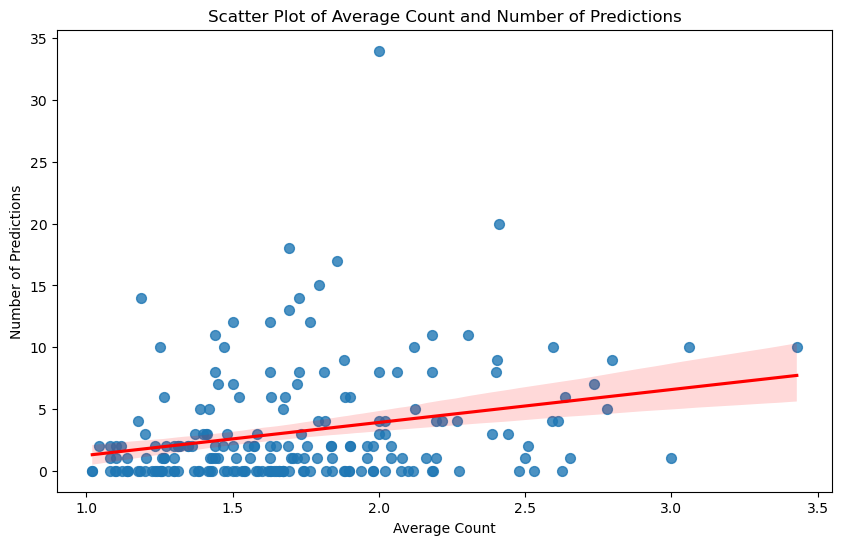

In [58]:
# Create a scatter plot with a regression line
plt.figure(figsize=(10, 6))
sns.regplot(x='average_count', y='num_predictions', data=average_bbox_number_per_image, scatter_kws={'s': 50}, line_kws={'color': 'red'})
plt.title('Scatter Plot of Average Count and Number of Predictions')
plt.xlabel('Average Count')
plt.ylabel('Number of Predictions')
plt.show()

# Does the symmetry test take longer if there are no detected objects?    

In [59]:
pd.options.mode.chained_assignment = None  # default='warn'

new_df = participant_boxes[['id', 'file_name', 's_rt']]
new_df.rename(columns={'file_name': 'Image', 'id': 'Participant_id'}, inplace=True)

grouped_df = new_df.drop(columns=['Participant_id']).groupby('Image').mean().reset_index()

grouped_df = grouped_df.merge(average_bbox_number_per_image, left_on='Image', right_on='file_name', how='left').drop(columns=['file_name'])
grouped_df.dropna(inplace=True)

correlation_s_rt_num_predictions = grouped_df['s_rt'].corr(grouped_df['num_predictions'])
print(f'The correlation between reaction time and the number of detected objects is {correlation_s_rt_num_predictions:.2f}')

The correlation between reaction time and the number of detected objects is 0.27


## Graph it

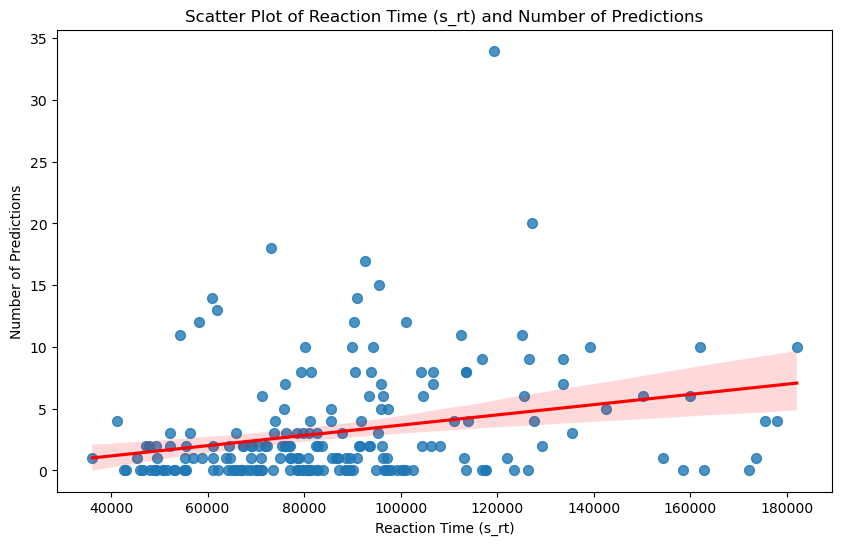

In [60]:
# Create a scatter plot with a regression line
plt.figure(figsize=(10, 6))
sns.regplot(x='s_rt', y='num_predictions', data=grouped_df, scatter_kws={'s': 50}, line_kws={'color': 'red'})
plt.title('Scatter Plot of Reaction Time (s_rt) and Number of Predictions')
plt.xlabel('Reaction Time (s_rt)')
plt.ylabel('Number of Predictions')
plt.show()

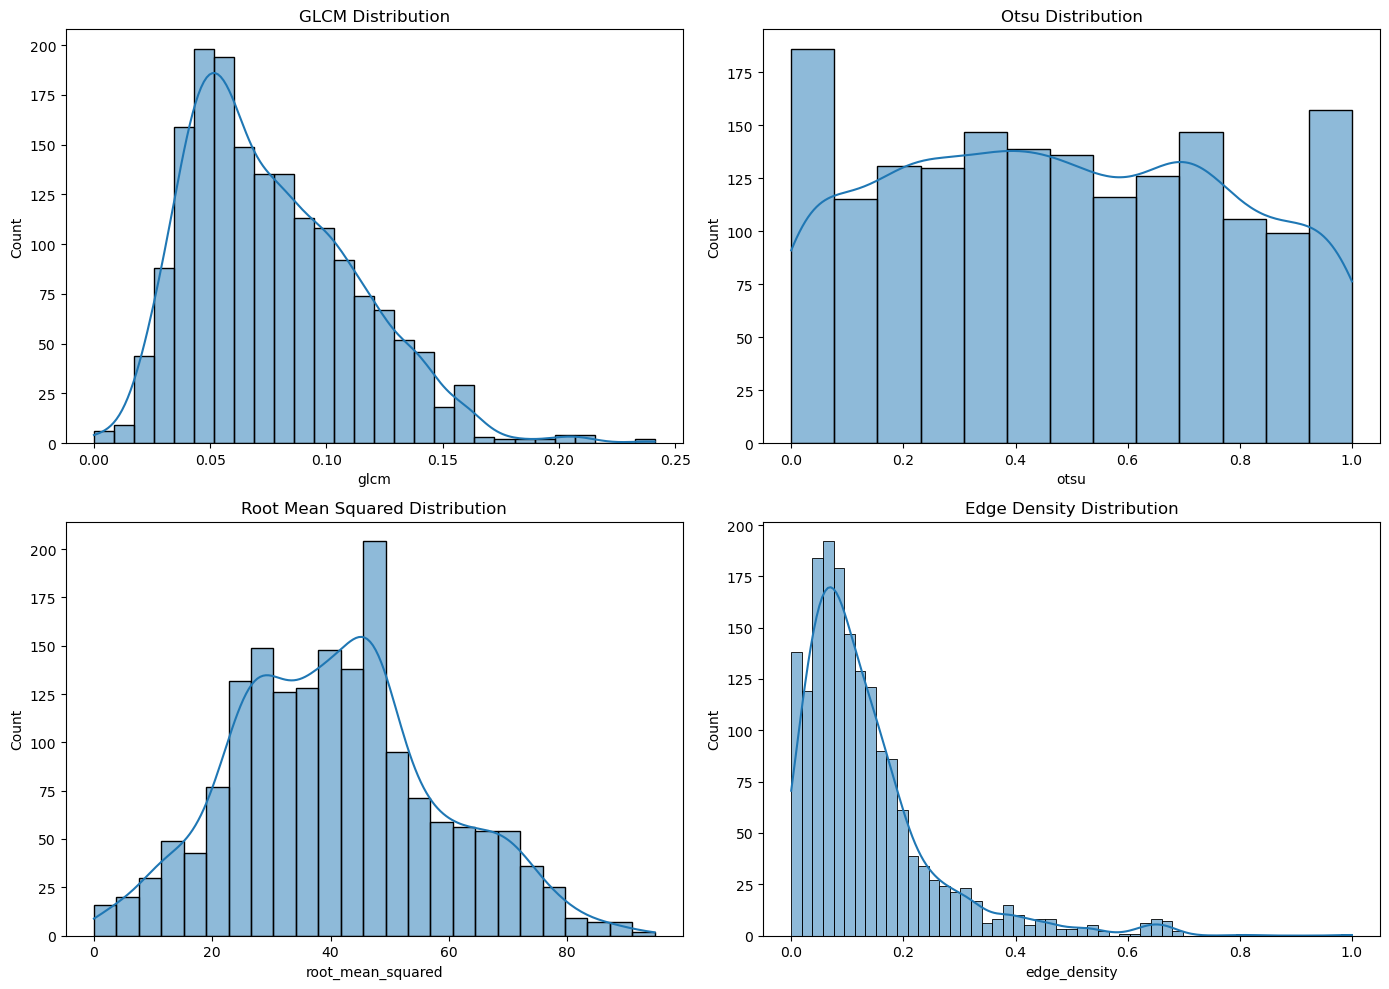

In [73]:
avobe_threshold = list(thresholded_boxes['box_id'])
filtered_homogeneity = homogeneity[homogeneity['box_id'].isin(avobe_threshold)].copy()

fig, ax = plt.subplots(2, 2, figsize=(14, 10))

sns.histplot(filtered_homogeneity['glcm'], kde=True, ax=ax[0, 0])
ax[0, 0].set_title('GLCM Distribution')

sns.histplot(filtered_homogeneity['otsu'], kde=True, ax=ax[0, 1])
ax[0, 1].set_title('Otsu Distribution')

sns.histplot(filtered_homogeneity['root_mean_squared'], kde=True, ax=ax[1, 0])
ax[1, 0].set_title('Root Mean Squared Distribution')

sns.histplot(filtered_homogeneity['edge_density'], kde=True, ax=ax[1, 1])
ax[1, 1].set_title('Edge Density Distribution')

plt.tight_layout()
plt.show()